# Benchmark results reporting

## Setup

### Prerequirements
This notebook requires a kernel running Python 3.5+.
You can skip this section if the kernel is already configured.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install openml
!pip install tabulate
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
#!jupyter nbextension enable python-markdown/main
#!pip install jupyter_nbextensions_configurator
#!jupyter nbextensions_configurator enable --user

### Imports and selection of the results directory

In [1]:
from IPython import display as ipyd
from IPython.display import FileLink, FileLinks
import functools as ft
import os

import pandas as pd
import numpy as np
import matplotlib as mp
import scipy as sp
import seaborn as sb
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

Matplotlib is building the font cache using fc-list. This may take a moment.


## Results

##### Parameters
Global variables:

In [2]:
nfolds = 10
ff = '%.6g'
colormap = 'tab10'
# colormap = 'Set2'
# colormap = 'Dark2'

renamings = dict(
    constantpredictor_enc='constantpredictor'
)
excluded_frameworks = ['oboe']
binary_score_label = 'AUC'
multiclass_score_label = 'logloss'

# impute_missing_with = 'constantpredictor'
impute_missing_with = 'randomforest'
zero_one_refs = ('constantpredictor', 'tunedrandomforest')

all_results_files = {
    'old': [
        "results_valid_ref.csv", "results_valid.csv",
        "results_small-2c1h_ref.csv", "results_small-2c1h.csv",
        "results_medium-4c1h_ref.csv", "results_medium-4c1h.csv",
        "results_medium-4c4h_ref.csv", "results_medium-4c4h.csv",
    ],
    '1h': [
        "results_small-8c1h_ref.csv", "results_small-8c1h.csv",
        "results_medium-8c1h_ref.csv", "results_medium-8c1h.csv",            
    ],
    '4h': [
        "results_small-8c4h_ref.csv", "results_small-8c4h.csv",
        "results_medium-8c4h_ref.csv", "results_medium-8c4h.csv",    
        "results_large-8c4h_ref.csv", "results_large-8c4h.csv",       
    ],
    '8h': [
        "results_large-8c8h_ref.csv", "results_large-8c8h.csv",        
    ]
}

results_group = '1h'
results_files = all_results_files[results_group]
tasks_sort_by = 'nrows'

#### Loading results, formatting and adding columns
- `result` is the raw result metric computed from predictions at the end the benchmark.
    For classification problems, it is usually `auc` for binomial classification and `logloss` for multinomial classification.
- `score` ensures a standard comparison between tasks: **higher is always better**.
- `norm_score` is a normalization of `score` on a `[0, 1]` scale, with `{{zero_one_refs[0]}}` score as `0` and `{{zero_one_refs[1]}}` score as `1`.
- `imp_result` and `imp_score` for imputed results/scores. Given a task and a framework:
    - if **all folds results/scores are missing**, then no imputation occurs, and the result is `nan` for each fold.
    - if **only some folds results/scores are missing**, then the missing result is imputed by the `{{impute_missing_with}}` result for this fold.

In [95]:
# global utility functions

class Namespace:  
    def __init__(self, **kwargs):
        self.__dict__.update(**kwargs)

    def __str__(self):
        return str(self.__dict__)

    def __repr__(self):
        return repr(self.__dict__)

    def extend(self, **kwargs):
        clone = Namespace(**self.__dict__)
        clone.__dict__.update(**kwargs)
        return clone

def create_file(*path_tokens):
    path = os.path.realpath(os.path.join(*path_tokens))
    if not os.path.exists(path):
        dirname, basename = os.path.split(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname, exist_ok=True)
        if basename:
            open(path, 'a').close()
    return path

def display(fr, pretty=True, float_format=ff):
    with pd.option_context(
        'display.max_rows', len(fr), 
        'display.float_format', lambda f: float_format % f
        ):
        if type(fr) is pd.Series:
            fr = fr.to_frame()
        if pretty and type(fr) is pd.DataFrame:
            fr.style.set_properties(**{'vertical-align':'top'})
            ipyd.display(ipyd.HTML(fr.to_html()))
        else:
            print(fr)


def sort_dataframe(df, by=None, axis=0):
    if axis == 1:
        cols = [col for col in df.columns]
        cols.sort(key=by) if by else cols.sort()
        return df[cols]
#         return df.sort_index(by, axis=1)
    else:
        if by:
            tmp_sort='tmp_sort'
            tmp_df = df.reset_index()
            tmp_df = tmp_df.assign(tmp_sort=by)
            tmp_df.set_index([*df.index.names, tmp_sort], inplace=True)
            tmp_df.sort_index(level=tmp_sort, inplace=True)
            tmp_df.set_index(tmp_df.index.droplevel(tmp_sort), inplace=True)
            return tmp_df
        return df.sort_index()


In [4]:
import openml as oml


def dataset_metadata(task_id):
#     print(f"loading {task_id}")
    tid = int(task_id.split("/")[2]) if task_id.startswith('openml.org') else int(task_id)
    task = oml.tasks.get_task(task_id=tid, download_data=False)
    dataset = oml.datasets.get_dataset(task.dataset_id, download_data=False)
    did = dataset.dataset_id
    name = dataset.name
    nrows = int(dataset.qualities['NumberOfInstances'])
    nfeatures = int(dataset.qualities['NumberOfFeatures'])
    nclasses = int(dataset.qualities['NumberOfClasses'])
    task_type = ('regression' if nclasses == 0 
                 else 'binary' if nclasses == 2 
                 else 'multiclass' if nclasses > 2 
                 else 'unknown')
#     print(f"loaded {name}")
    return Namespace(
        task=f"openml.org/t/{tid}",
        dataset=f"openml.org/d/{did}",
        type=task_type,
        name=name,
        nrows=nrows,
        nfeatures=nfeatures,
        nclasses=nclasses,
    )


def load_dataset_metadata(results):
    tids = results.id.unique()
    # task names are hardcoded in benchmark definitions, so we need to map them with their task id
    lookup_df = results.filter(items=['id', 'task'], axis=1).drop_duplicates()
    lookup_map = {rec['id']:rec['task'] for rec in lookup_df.to_dict('records')}
#     print(lookup_map)
    metadata = {lookup_map[m.task]:m for m in [dataset_metadata(tid) for tid in tids]}
    return metadata


def save_metadata(metadata, filename='metadata.csv'):
    df = pd.DataFrame([m.__dict__ for m in metadata.values()], 
                      columns=['task', 'name', 'type', 'dataset', 'nrows', 'nfeatures', 'nclasses'])
    df.sort_values(by='name', inplace=True)
    df.to_csv(filename, index=False)


In [7]:
# results loading + processing functions

def load_results(files):
    return pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

                
def task_prop(row, metadata, prop):
    return getattr(metadata.get(row.task), prop)


def impute_result(row, results_df, res_col='result', ref_framework=impute_missing_with):
    if pd.notna(row[res_col]):
        return row[res_col]
    # if all folds are failed or missing, don't impute
    if pd.isna(results_df.loc[(results_df.task==row.task)&(results_df.framework==row.framework)][res_col]).all():
        return np.nan
    # impute with ref framework corresponding value
    return (results_df.loc[(results_df.framework==ref_framework)
                           &(results_df.task==row.task)
                           &(results_df.fold==row.fold)][res_col]
                     .item())


def imputed(row):
    return pd.isna(row.result) and pd.notna(row.imp_result)
    

def score(row, res_col='result'):
    return row[res_col] if row[res_col] in [row.auc, row.acc]\
                        else - row[res_col]


def norm_score(row, results_df, score_col='score', zero_one_refs=zero_one_refs):
    zero, one = (results_df.loc[(results_df.framework==ref)
                                &(results_df.task==row.task)
                                &(results_df.fold==row.fold)][score_col]
                           .item()
                 for ref in zero_one_refs)
    return (row[score_col] - zero) / (one - zero)
 
    
def sorted_ints(arr): 
    return sorted(list(map(int, arr[~np.isnan(arr)])))


def prepare_results(results_files, exclude=excluded_frameworks):
    results = load_results(results_files).replace(renamings)
    if exclude:
        results = results.loc[~results.framework.isin(exclude)]
    results.task = results.task.str.lower()
    results.framework = results.framework.str.lower()
    results.fold = results.fold.apply(int)

    frameworks = results.framework.unique()
    frameworks.sort()
    
    tasks = results.task.unique()
    tasks.sort()
    
    folds = results.fold.unique()
    
    metadata = load_dataset_metadata(results)

    done = results.set_index(['task', 'fold', 'framework'])
    if not done.index.is_unique:
        print("Duplicate entries:")
        display(done[done.index.duplicated(keep=False)]
                    .sort_values(by=done.index.names), 
                pretty=False)
    assert done.index.is_unique
    
    missing = (pd.DataFrame([(task, fold, framework, 'missing') 
                             for task in tasks 
                             for fold in range(nfolds)
                             for framework in frameworks 
                             if (task, fold, framework) not in done.index],
                            columns=[*done.index.names, 'info'])
                 .set_index(done.index.names))
    assert missing.index.is_unique
    failed = (results.loc[pd.notna(results['info'])]
                     .set_index(done.index.names))
    assert failed.index.is_unique

    # extending the data frame 
    results = results.append(missing.reset_index())
    results['type'] = [task_prop(row, metadata, 'type') for _, row in results.iterrows()]
    results['score'] = [score(row) for _, row in results.iterrows()]
    results['imp_result'] = [impute_result(row, results) for _, row in results.iterrows()]
    results['imp_score'] = [impute_result(row, results, 'score') for _, row in results.iterrows()]
    results['norm_score'] = [norm_score(row, results, 'imp_score') for _, row in results.iterrows()]

    return Namespace(
        results=results,
        frameworks=frameworks,
        tasks=tasks,
        folds=folds,
        metadata=metadata,
        done=done,
        missing=missing,
        failed=failed
    )

In [8]:
# load result files
res = prepare_results(results_files)
res.results.to_csv(create_file("tables", results_group, "all_results.csv"), 
                   index=False, 
                   float_format=ff)
save_metadata(res.metadata, filename=create_file("datasets", results_group, "metadata.csv"))

### Tasks list

In [9]:
tasks = (res.results.groupby(['task', 'type'])['id']
                    .unique()
                    .map(lambda id: id[0]))
display(tasks)

,,id
task,type,
adult,binary,openml.org/t/7592
amazon_employee_access,binary,openml.org/t/34539
apsfailure,binary,openml.org/t/168868
australian,binary,openml.org/t/146818
bank-marketing,binary,openml.org/t/14965
blood-transfusion,binary,openml.org/t/10101
car,multiclass,openml.org/t/146821
christine,binary,openml.org/t/168908
cnae-9,multiclass,openml.org/t/9981


### Completed tasks/folds

In [10]:
done = (res.done.reset_index()
                .groupby(['task', 'framework'])['fold']
                .unique())
display(done, pretty=False)
# display(tabulate(done, tablefmt='plain'))

                                                                                    fold
task                                   framework                                        
adult                                  autosklearn        [1, 0, 2, 4, 5, 8, 7, 9, 6, 3]
                                       autoweka           [4, 5, 6, 9, 0, 2, 1, 3, 8, 7]
                                       constantpredictor  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       h2oautoml          [2, 4, 5, 8, 0, 1, 3, 6, 7, 9]
                                       randomforest       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       tpot               [0, 3, 4, 6, 7, 8, 1, 9, 5, 2]
                                       tunedrandomforest  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
amazon_employee_access                 autosklearn        [2, 0, 5, 6, 1, 9, 3, 7, 8, 4]
                                       autoweka           [6, 3, 5, 8, 7, 9, 1, 0, 2, 4]
                     

### Missing or crashed/aborted tasks/folds

In [11]:
# not_done = pd.DataFrame([(task, framework) for task in res.tasks 
#                                            for framework in res.frameworks 
#                                            if (task, framework) not in done.index],
#                         columns=['task', 'framework'])
# missing = res.results.append(not_done)\
#                      .groupby(['task', 'framework'])['fold']\
#                      .unique()\
#                      .map(sorted_ints)\
#                      .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
#                      .where(lambda values: values.map(lambda arr: len(arr) > 0))\
#                      .dropna()

missing = (res.missing.reset_index()
                      .groupby(['task', 'framework'])['fold']
                      .unique())
display(missing, pretty=False)

Empty DataFrame
Columns: [fold]
Index: []


### Failing tasks/folds

In [12]:
# failed = res.results.where(np.isnan(all_results.result))\
#                     .groupby(['task', 'framework'])['fold']\
#                     .unique()\
#                     .map(sorted_ints)

failed = (res.failed.reset_index()
                    .groupby(['task', 'framework'])['fold']
                    .unique())
display(failed, pretty=False)

                                                          fold
task               framework                                  
helena             autoweka                                [8]
                   h2oautoml                   [0, 1, 4, 7, 9]
kc1                autosklearn                             [6]
kddcup09_appetency autoweka                 [4, 9, 5, 8, 1, 6]
                   tpot                                    [5]
riccardo           autoweka     [0, 1, 2, 3, 4, 6, 5, 7, 8, 9]
robert             autoweka     [1, 0, 2, 3, 4, 5, 7, 6, 8, 9]


### Results anomalies

In [13]:
def list_outliers(col, results, z_threshold=3):
    df = results.pivot_table(index=['type','task', 'framework'], columns='fold', values=col)
    df_mean = df.mean(axis=1)
    df_std = df.std(axis=1)
    z_score = (df.sub(df_mean, axis=0)
                 .div(df_std, axis=0)
                 .abs())
    return z_score.where(z_score > z_threshold).dropna(axis=0, how='all')
    
display(list_outliers('result', 
                      results=res.results,
#                       results=res.results.loc[res.results.framework=='h2oautoml']
                      z_threshold=2.5,
                     ))

## Data reports

In [14]:
# common functions for data reports

def add_imputed_mark(values, imp, val_type=float, val_format=None):
    formats = dict(float="{:,.6g}{}", int="{0:d}{}", str="{}{}")
    format_value = (val_format if val_format is not None
                               else lambda *val: formats[val_type.__name__].format(*val))
    return (values.astype(object)
                  .combine(imp, 
                           lambda val, imp: format_value(val, " ({:.0g})".format(imp) if imp else '')))


### Results summary

Averaging using arithmetic mean over fold `result` or `score`.
In following summaries, if not mentioned otherwise, the means are computed over imputed results/scores.
Given a task and a framework:
- if **all folds results/scores are missing**, then no imputation occured, and the mean result is `nan`.
- if **only some folds results/scores are missing**, then the amount of imputed results that contributed to the mean are displayed between parenthesis.

In [15]:
def render_summary(col, results, show_imputations=True, filename=None, float_format=ff):
    res_group = results.groupby(['type', 'task', 'framework'])
    df = res_group[col].mean().unstack()
    if show_imputations:
        imputed_df = (res_group['result', 'imp_result']
                          .apply(lambda df: sum(imputed(row) for _, row in df.iterrows()))
                          .unstack())    
        df = df.combine(imputed_df, ft.partial(add_imputed_mark, 
                                               val_format=lambda *v: (float_format+"%s") % tuple(v)))
    display(df, float_format=float_format)
    if filename is not None:
        df.to_csv(create_file("tables", results_group, filename), float_format=float_format)

In [16]:
summary_results = res.results

#### Number of models trained

When available, displays the average amount of models trained by the framework for each dataset.

This amount should be interpreted differently for each framework.
For example, with *RandomForest*, this amount corresponds to the number of trees.

In [17]:
render_summary('models', 
               results=summary_results, 
               filename="models_summary.csv", 
               float_format="%.f")

#### Results mean

In [18]:
render_summary('result', 
               results=summary_results)

In [19]:
render_summary('imp_result', 
               results=summary_results,
               filename="result_summary.csv")

#### Score mean

In [20]:
render_summary('imp_score', 
               results=summary_results,
               filename="score_summary.csv")

In [21]:
render_summary('norm_score', 
               results=summary_results,
               filename="norm_score_summary.csv")

### Tasks leaderboard

In [22]:
def rank(scores):
    sorted_scores = pd.Series(scores.unique()).sort_values(ascending=False)
    ranks = pd.Series(index=scores.index)
    for idx, value in scores.items():
        try:
            ranks.at[idx] = np.where(sorted_scores == value)[0][0]+1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

def render_leaderboard(col, results, aggregate=False, show_imputations=False, filename=None):
    res_group = results.groupby(['type', 'task', 'framework'])
    df = (res_group[col].mean().unstack() if aggregate 
          else results.pivot_table(index=['type','task', 'fold'], columns='framework', values=col))
    df = (df.apply(rank, axis=1, result_type='broadcast')
            .astype(object)) 
    if show_imputations:
        imputed_df = (res_group['result', 'imp_result']
                          .apply(lambda df: sum(imputed(row) for _, row in df.iterrows()))
                          .unstack())    
        df = df.combine(imputed_df, add_imputed_mark)
    display(df)
    if filename is not None:
        df.to_csv(create_file("tables", results_group, filename), float_format='%.f')

In [23]:
leaderboard_results = res.results.loc[~res.results.framework.isin(['constantpredictor', 'randomforest'])]

In [24]:
render_leaderboard('imp_score', 
                   results=leaderboard_results,
                   aggregate=True, 
                   show_imputations=True, 
                   filename="tasks_leaderboard.csv")

### Folds leaderboard

In [25]:
render_leaderboard('score', 
                   results=res.results,
                   filename="folds_leaderboard.csv");

## Visualizations

In [26]:
# common functions for visualizations

def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    

def task_labels(index):
    max_length = 16
    return (index.droplevel('type')
                .map(lambda x: x if len(x) <= max_length else u'{}…'.format(x[:max_length-1]))
                .values)

def set_labels(axes, 
               title=None,
               xlabel=None, ylabel=None,
               x_labels=None, y_labels=None,
               x_tick_params=None, y_tick_params=None,
               legend_title=None):
    
    axes.set_title('' if not title else title, fontsize='xx-large')
    axes.set_xlabel('' if not xlabel else xlabel, fontsize='x-large')
    axes.set_ylabel('' if not ylabel else ylabel, fontsize='x-large')
    if not x_tick_params:
        x_tick_params = {}
    if not y_tick_params:
        y_tick_params = {}
    axes.tick_params(axis='x', labelsize='x-large', **x_tick_params)
    axes.tick_params(axis='y', labelsize='x-large', **y_tick_params)
    if x_labels is not None:
        axes.set_xticklabels(x_labels)
    if y_labels is not None:
        axes.set_yticklabels(y_labels)
    legend = axes.get_legend()
    if legend:
        legend_title = legend_title or legend.get_title().get_text()
        legend.set_title(legend_title, prop=dict(size='x-large'))
        for text in legend.get_texts():
            text.set_fontsize('x-large')
            
def set_scales(axes, xscale=None, yscale=None):
    if isinstance(xscale, str):
        axes.set_xscale(xscale)
    elif isinstance(xscale, tuple):
        axes.set_xscale(xscale[0], **xscale[1])
    if isinstance(yscale, str):
        axes.set_yscale(yscale)
    elif isinstance(yscale, tuple):
        axes.set_yscale(yscale[0], **yscale[1])


### Heatmaps

In [103]:
def draw_heatmap(df, 
                 x_labels=True, y_labels=True, 
                 title=None, xlabel=None, ylabel=None,
                 **kwargs):
    with sb.axes_style('white'), sb.plotting_context('paper'):
#         print(sb.axes_style())
#         print(sb.plotting_context())
        axes = sb.heatmap(df, xticklabels=x_labels, yticklabels=y_labels,
                          annot=True, cmap='RdYlGn', robust=True,
                          **kwargs)
        set_labels(axes, title=title, 
                   xlabel=xlabel, ylabel=ylabel,
                   x_tick_params=dict(labelrotation=90))
        fig = axes.get_figure()
        fig.set_size_inches(10, df.shape[0]/2)
        fig.set_dpi(120)
        return fig
    
def draw_score_heatmap(col, results, type_filter='all', metadata=None, y_sort_by=None,
                       filename=None, **kwargs):
    df = (results.groupby(['type', 'task', 'framework'])[col]
                 .mean()
                 .unstack())
    df = (df if type_filter == 'all'
             else df[df.index.get_loc(type_filter)])
    if metadata and y_sort_by:
        sort_by = lambda row: row.task.apply(lambda t: getattr(metadata[t], y_sort_by))
        df = sort_dataframe(df, by=sort_by)
    
    fig = draw_heatmap(df, 
                       y_labels=task_labels(df.index), 
#                        xlabel="Framework", ylabel="Task",
                       **kwargs)
    if filename is not None:
        savefig(fig, create_file("graphics", results_group, filename))
    return fig


In [104]:
# heatmap_results = res.results.loc[~res.results.framework.isin(['constantpredictor', 'randomforest'])]
heatmap_results = res.results.loc[~res.results.framework.isin(['constantpredictor'])]

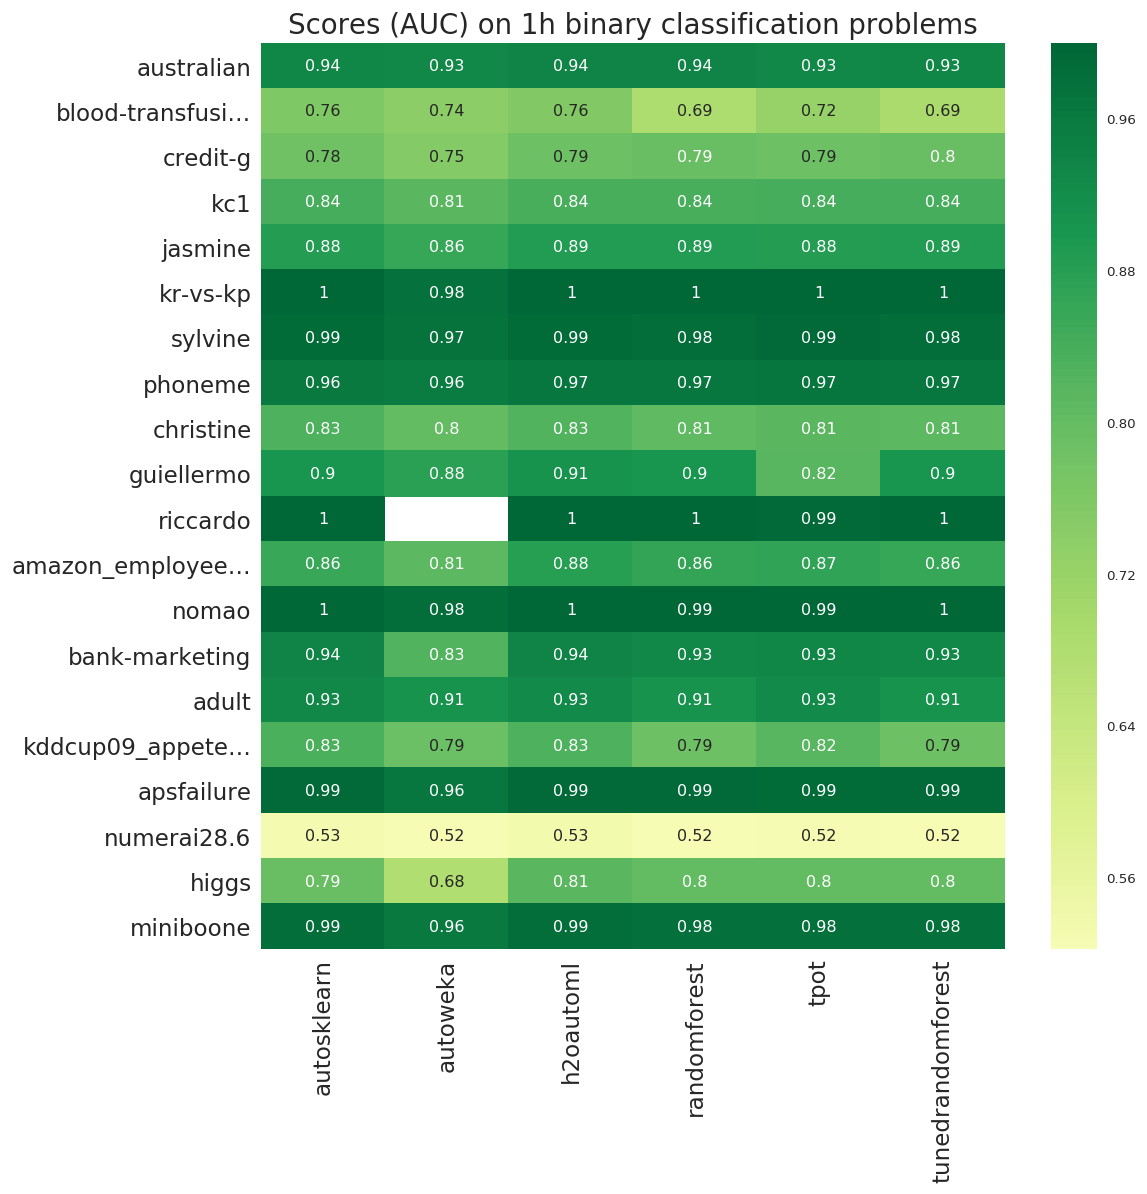

In [105]:
draw_score_heatmap('imp_score',
                   results=heatmap_results,
                   type_filter='binary', 
                   metadata=res.metadata,
                   y_sort_by=tasks_sort_by,
                   title=f"Scores ({binary_score_label}) on {results_group} binary classification problems",
                   filename="binary_score_heat.png",
                   center=0.5);

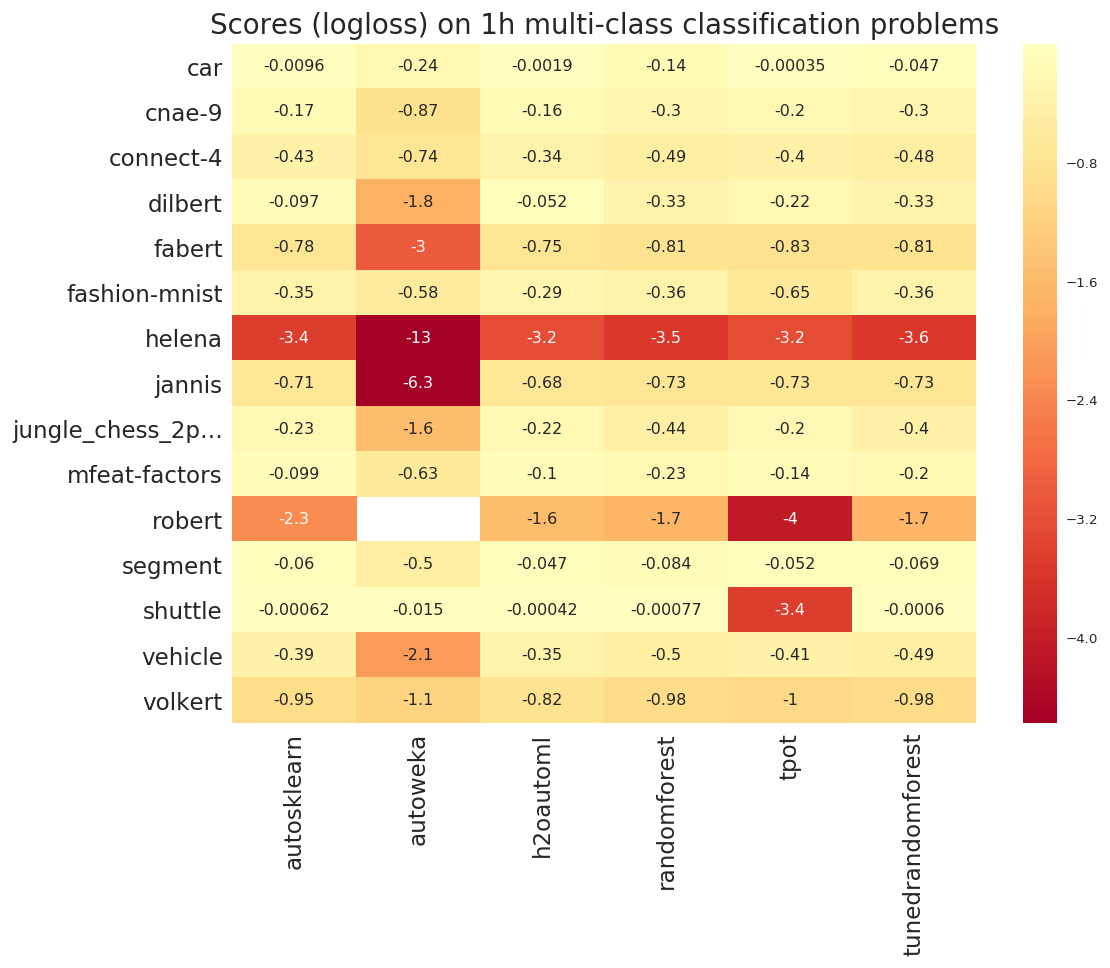

In [30]:
draw_score_heatmap('imp_score', 
                   results=heatmap_results,
                   type_filter='multiclass', 
                   y_sort_by=tasks_sort_by,
                   title=f"Scores ({multiclass_score_label}) on {results_group} multi-class classification problems",
                   filename="multiclass_score_heat.png",
                   center=0);

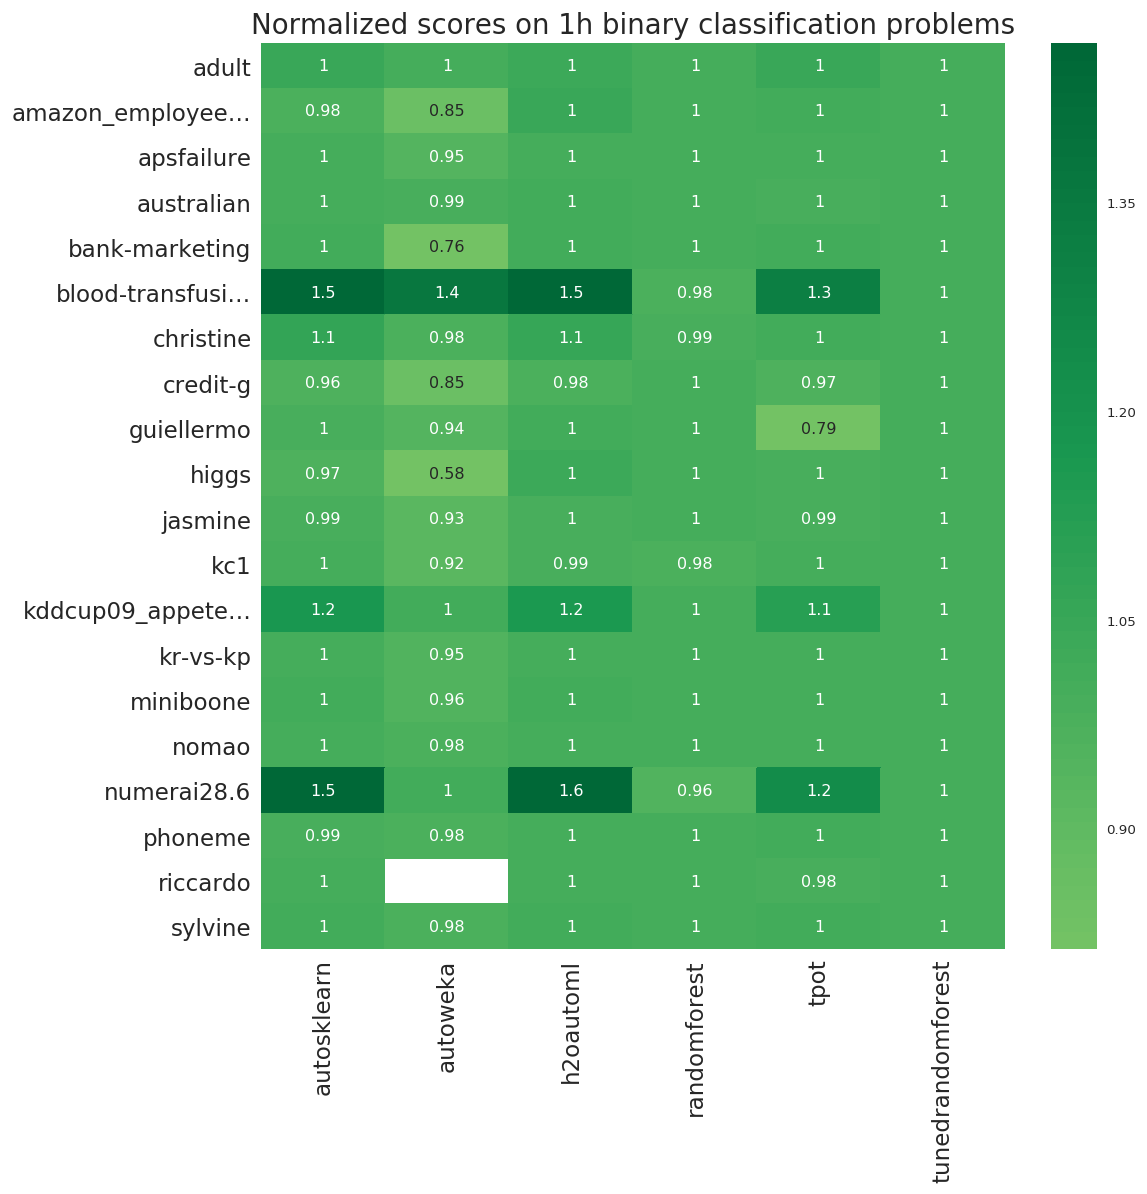

In [31]:
draw_score_heatmap('norm_score', 
                   results=heatmap_results,
                   type_filter='binary', 
                   y_sort_by=tasks_sort_by,
                   title=f"Normalized scores on {results_group} binary classification problems",
                   filename="binary_norm_score_heat.png",
                   center=0);

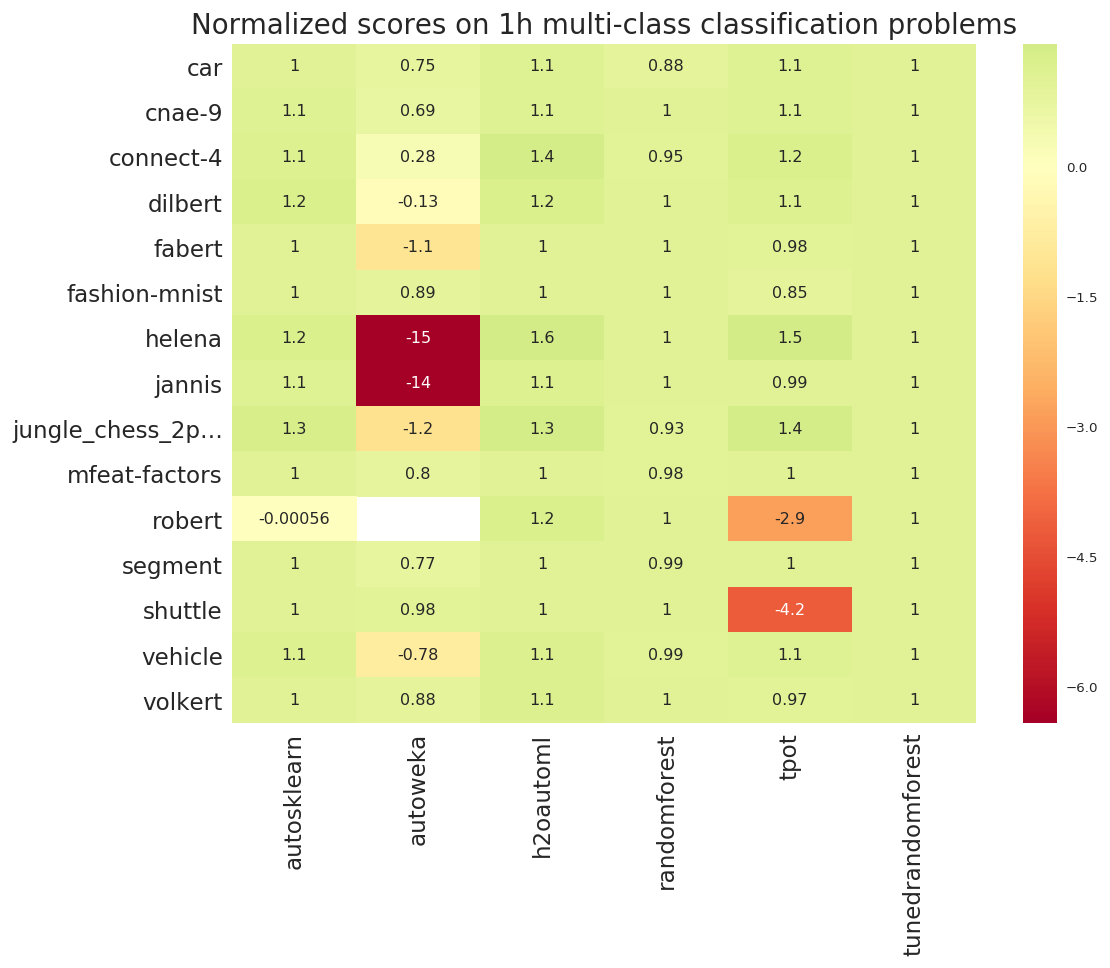

In [32]:
draw_score_heatmap('norm_score',
                   results=heatmap_results,
                   type_filter='multiclass', 
                   y_sort_by=tasks_sort_by,
                   title=f"Normalized scores on {results_group} multi-class classification problems",
                   filename="multiclass_norm_score_heat.png",
                   center=0);

### Linear plots

In [64]:
def draw_parallel_coord(df, class_column, 
                        x_labels=True, yscale='linear', 
                        title=None, xlabel=None, ylabel=None,
                        legend_loc='best', legend_title=None, colormap=colormap):
    with sb.axes_style('ticks', rc={'grid.linestyle': 'dotted'}), sb.plotting_context('paper'):
#         print(sb.axes_style())
        parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, df.shape[0]))
        # select the first colors from the colormap to ensure we use the same colors as in the stripplot later
        colors = mp.cm.get_cmap(colormap).colors[:len(df[class_column].unique())]
        axes = pd.plotting.parallel_coordinates(df, 
                                                class_column=class_column, 
                                                colors=colors,
                                                axvlines=False,
                                               )
        set_scales(axes, yscale=yscale)
        handles, labels = axes.get_legend_handles_labels()
        axes.legend(handles, labels, loc=legend_loc, title=legend_title)
        set_labels(axes, title=title, xlabel=xlabel, ylabel=ylabel, x_labels=x_labels,
                   x_tick_params=dict(labelrotation=90))
        return parallel_fig


def draw_score_parallel_coord(col, results, type_filter='all', metadata=None,
                              x_sort_by='name', ylabel=None, filename=None,
                              **kwargs):
    res_group = results.groupby(['type', 'task', 'framework'])
    df = res_group[col].mean().unstack(['type', 'task'])
    df = df if type_filter == 'all' \
            else df.iloc[:, df.columns.get_loc(type_filter)]
    if metadata:
        sort_by = lambda cols: getattr(metadata[cols[1]], x_sort_by)
        df = sort_dataframe(df, by=sort_by, axis=1)
    df.reset_index(inplace=True)
    fig = draw_parallel_coord(df, 
                              'framework',
                              x_labels=task_labels(df.columns.drop('framework')),
#                               xlabel="Task",
                              ylabel=ylabel or "Score",
                              legend_title="Framework",
                              **kwargs) 
    if filename is not None:
        savefig(fig, create_file("graphics", results_group, filename))
    return fig


In [65]:
# parallel_coord_results = res.results.loc[~res.results.framework.isin(['randomforest'])]
parallel_coord_results = res.results

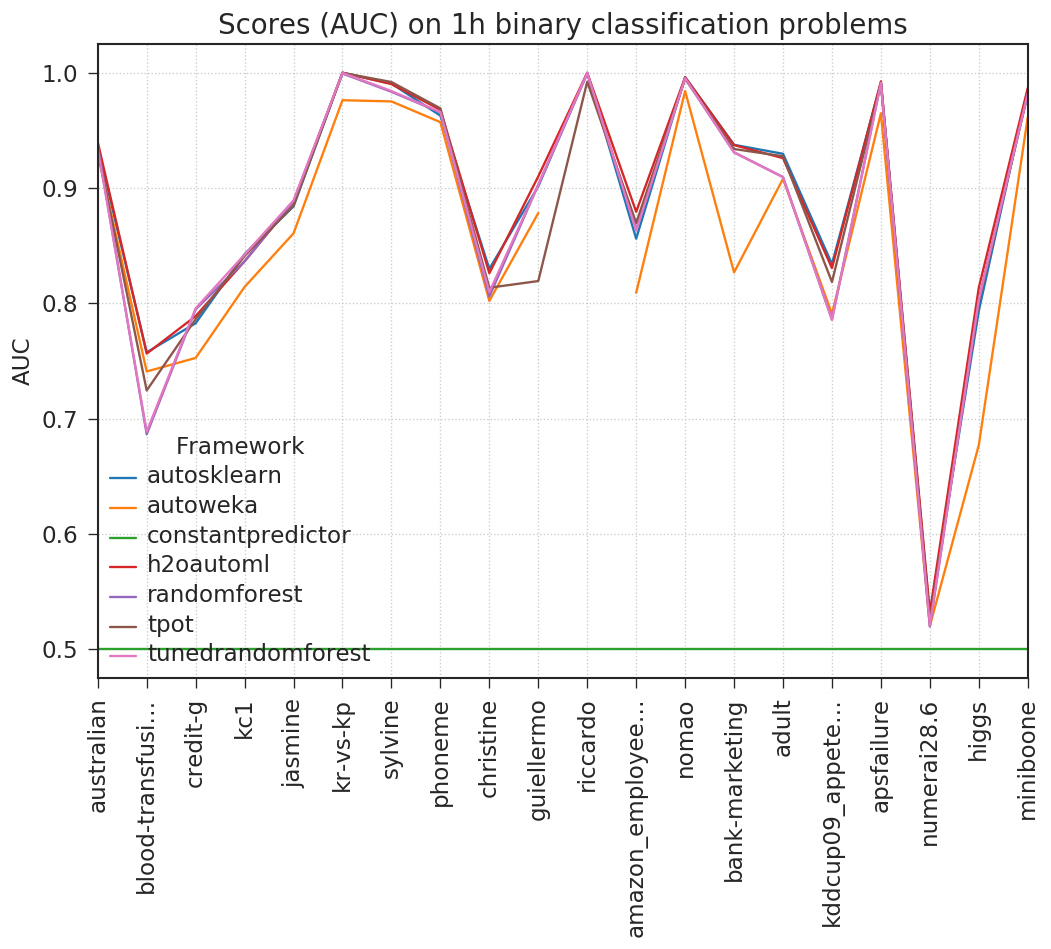

In [66]:
draw_score_parallel_coord('imp_score',
                          results=parallel_coord_results,
                          type_filter='binary', 
                          metadata=res.metadata,
                          x_sort_by=tasks_sort_by,
                          title=f"Scores ({binary_score_label}) on {results_group} binary classification problems",
                          ylabel=binary_score_label,
                          legend_loc='lower left',
                          filename="binary_score_parallel_ccord.png"
                         );


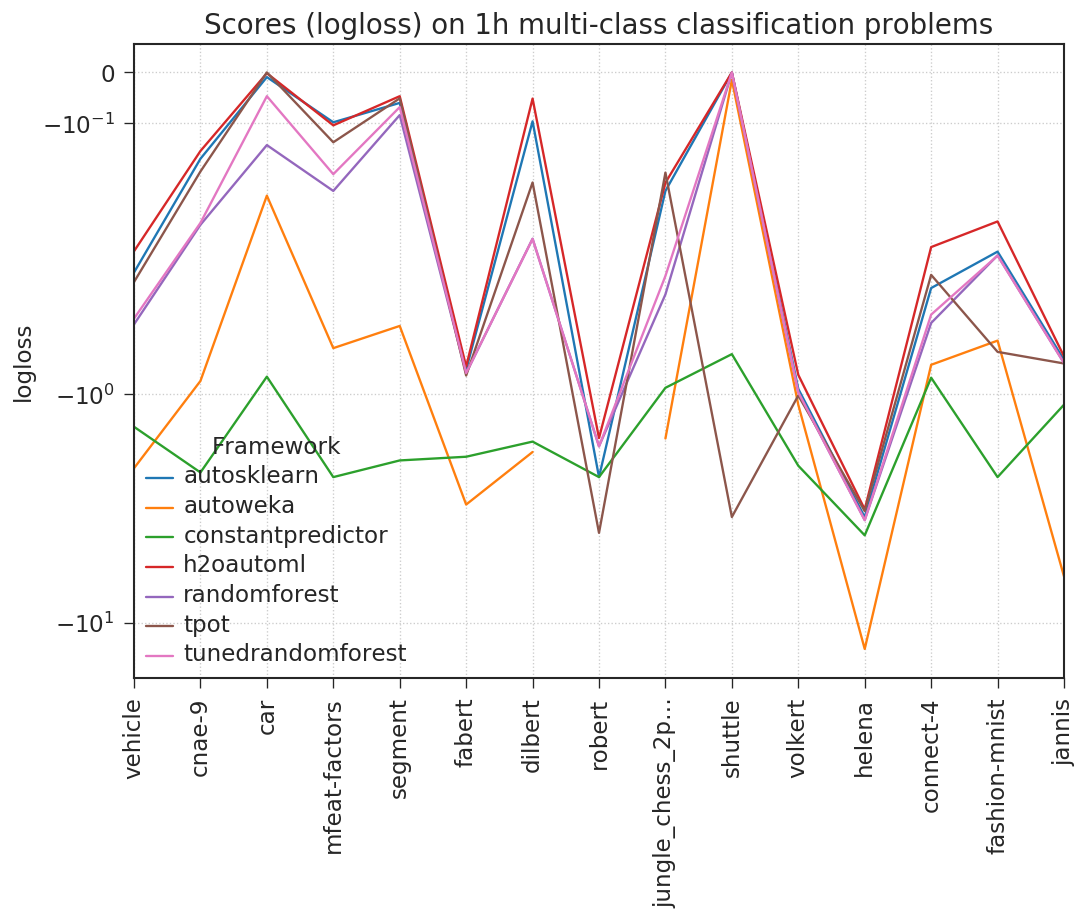

In [36]:
draw_score_parallel_coord('imp_score',
                          results=parallel_coord_results,
                          type_filter='multiclass',
                          metadata=res.metadata,
                          x_sort_by=tasks_sort_by,
                          title=f"Scores ({multiclass_score_label}) on {results_group} multi-class classification problems",
                          ylabel=multiclass_score_label,
                          yscale=('symlog', dict(linthreshy=0.5)),
                          legend_loc='lower left',
                          filename="multiclass_score_parallel_ccord.png"
                         );


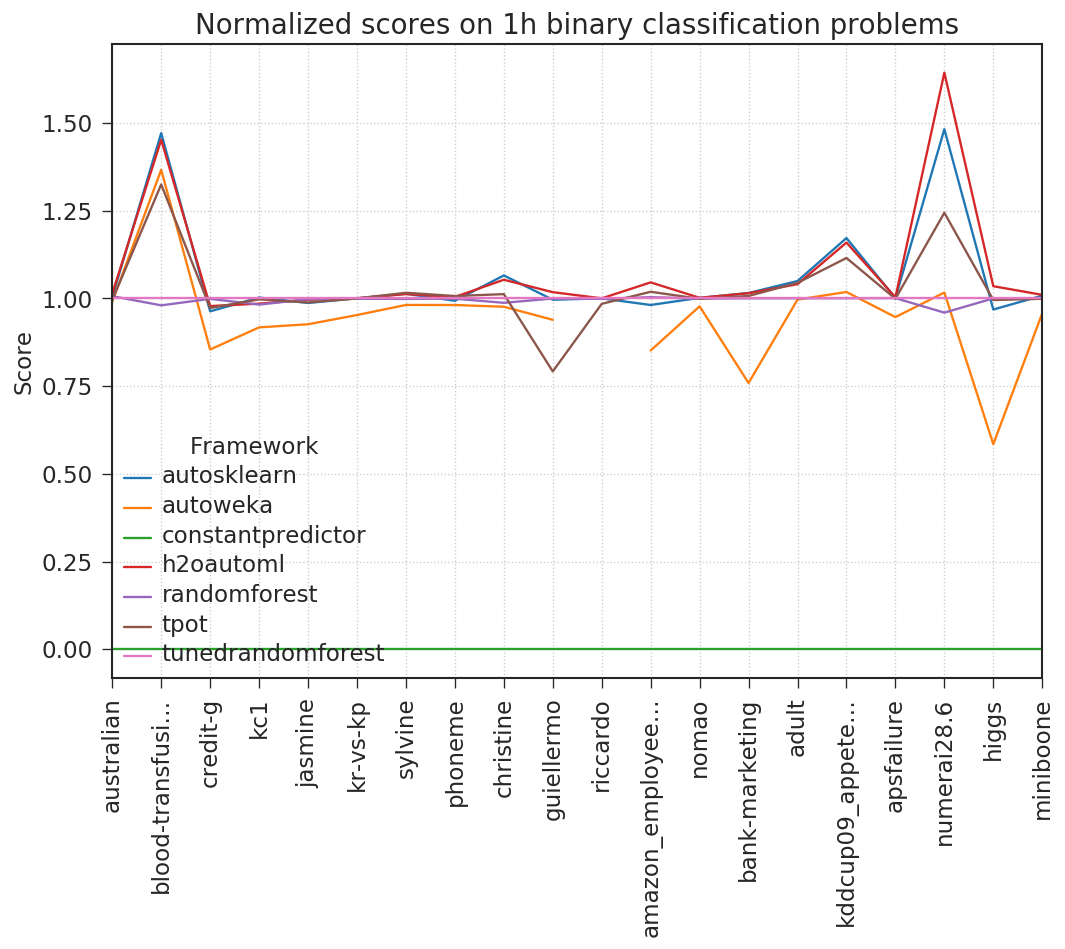

In [37]:
draw_score_parallel_coord('norm_score', 
                          results=parallel_coord_results,
                          type_filter='binary', 
                          metadata=res.metadata,
                          x_sort_by=tasks_sort_by,
                          title=f"Normalized scores on {results_group} binary classification problems",
                          filename="binary_norm_score_parallel_ccord.png"
                         );


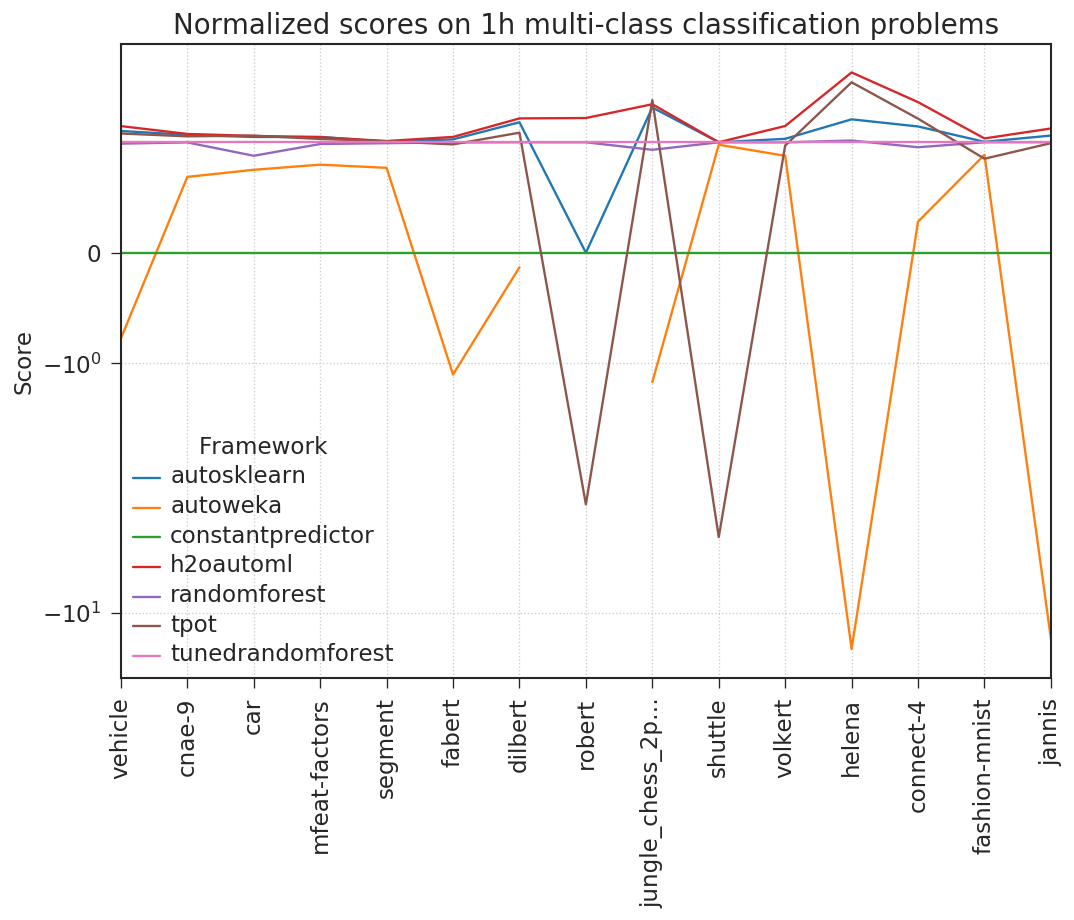

In [38]:
draw_score_parallel_coord('norm_score', 
                          results=parallel_coord_results,
                          type_filter='multiclass',
                          metadata=res.metadata,
                          x_sort_by=tasks_sort_by,
                          title=f"Normalized scores on {results_group} multi-class classification problems",
                          filename="multiclass_norm_score_parallel_ccord.png", 
                          yscale='symlog',
                         );


### Scatterplots

In [96]:
def draw_stripplot(df, x, y, hue, 
                   xscale='linear', xbound=None, 
                   xlabel=None, ylabel=None, y_labels=None, title=None,
                   legend_title=None, legend_loc='best', colormap=colormap):
    with sb.axes_style('whitegrid', rc={'grid.linestyle': 'dotted'}), sb.plotting_context('paper'):
#         print(sb.axes_style())
        # Initialize the figure
        strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(10, len(df.index.unique())))
        set_scales(axes, xscale=xscale)
        if xbound is not None:   
            axes.set_autoscalex_on(False)
            axes.set_xbound(*xbound)
#             axes.invert_xaxis()
        sb.despine(bottom=True, left=True)

        # Show each observation with a scatterplot
        sb.stripplot(x=x, y=y, hue=hue,
                     data=df, dodge=True, jitter=True, palette=colormap,
                     alpha=.25, zorder=1)

        # Show the conditional means
        sb.pointplot(x=x, y=y, hue=hue,
                     data=df, dodge=.5, join=False, palette=colormap,
                     markers='d', scale=.75, ci=None)

        # Improve the legend 
        handles, labels = axes.get_legend_handles_labels()
        dist = int(len(labels)/2)
        axes.legend(handles[dist:], labels[dist:], title=legend_title or hue,
                    handletextpad=0, columnspacing=1,
                    loc=legend_loc, ncol=1, frameon=True)
        set_labels(axes, title=title, xlabel=xlabel, ylabel=ylabel, y_labels=y_labels)
        return strip_fig
 

def draw_score_stripplot(col, results, type_filter='all', metadata=None,
                         y_sort_by='name', filename=None, **kwargs):
    sort_by = (None if not metadata 
               else lambda row: row.task.apply(lambda t: getattr(metadata[t], y_sort_by)))
    scatterplot_df = sort_dataframe(results.set_index(['type', 'task']), by=sort_by)
    df = scatterplot_df if type_filter == 'all' \
                        else scatterplot_df[scatterplot_df.index.get_loc(type_filter)]
    fig = draw_stripplot(
        df,
        x=col,
        y=df.index,
        hue='framework',
#         ylabel='Task',
        y_labels=task_labels(df.index.unique()),
        legend_title="Framework",
        **kwargs
    )
    if filename is not None:
        savefig(fig, create_file("graphics", results_group, filename))
    return fig


In [97]:
# scatterplot_results = (res.results.loc[~res.results.framework.isin(['randomforest'])]
#                                   .sort_values(by=['framework']))  # sorting for colors consistency
scatterplot_results = res.results.sort_values(by=['framework'])  # sorting for colors consistency

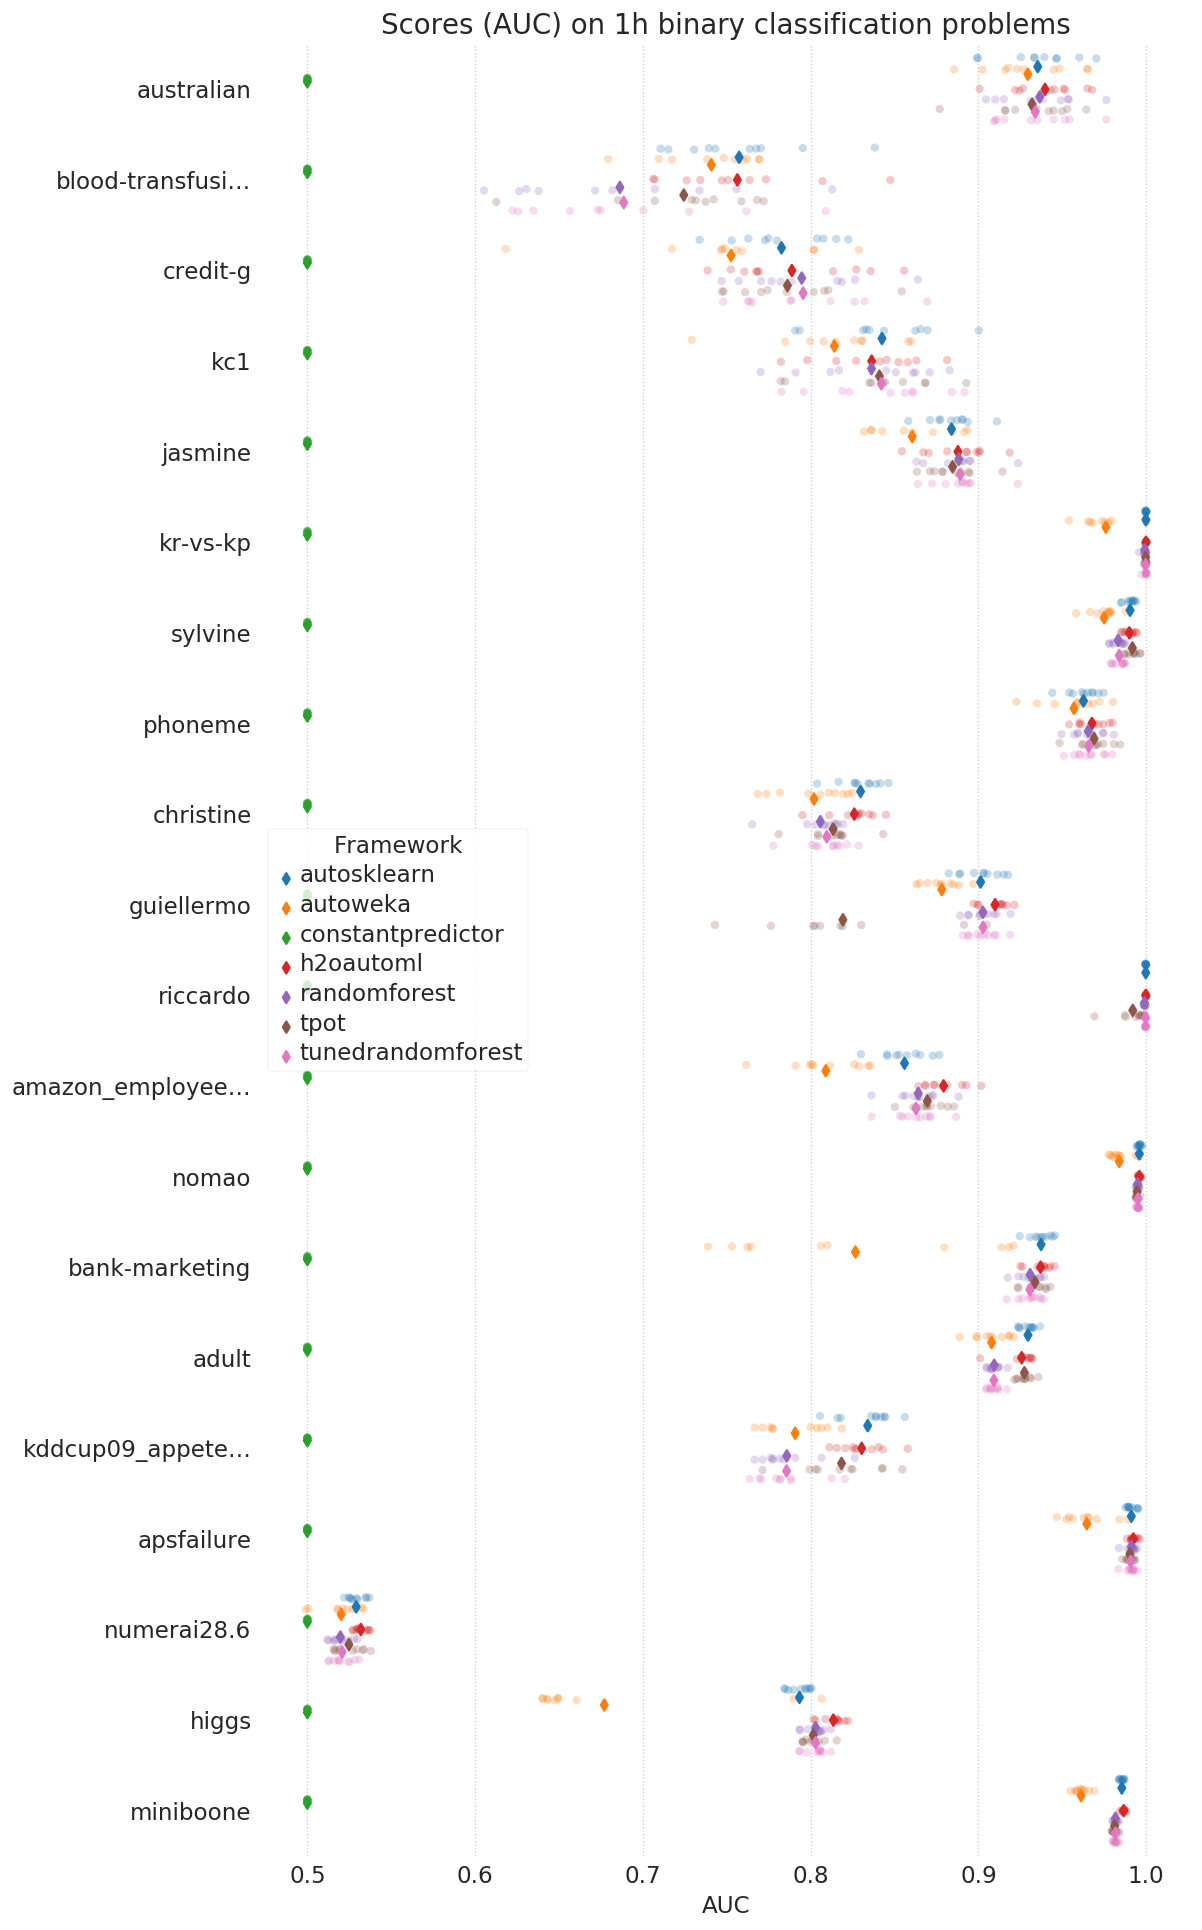

In [98]:
draw_score_stripplot('imp_result', 
                     results=scatterplot_results,
                     type_filter='binary', 
                     metadata=res.metadata,
                     y_sort_by=tasks_sort_by,
                     title=f"Scores ({binary_score_label}) on {results_group} binary classification problems",
                     xlabel=binary_score_label,
                     filename="binary_results_stripplot.png");

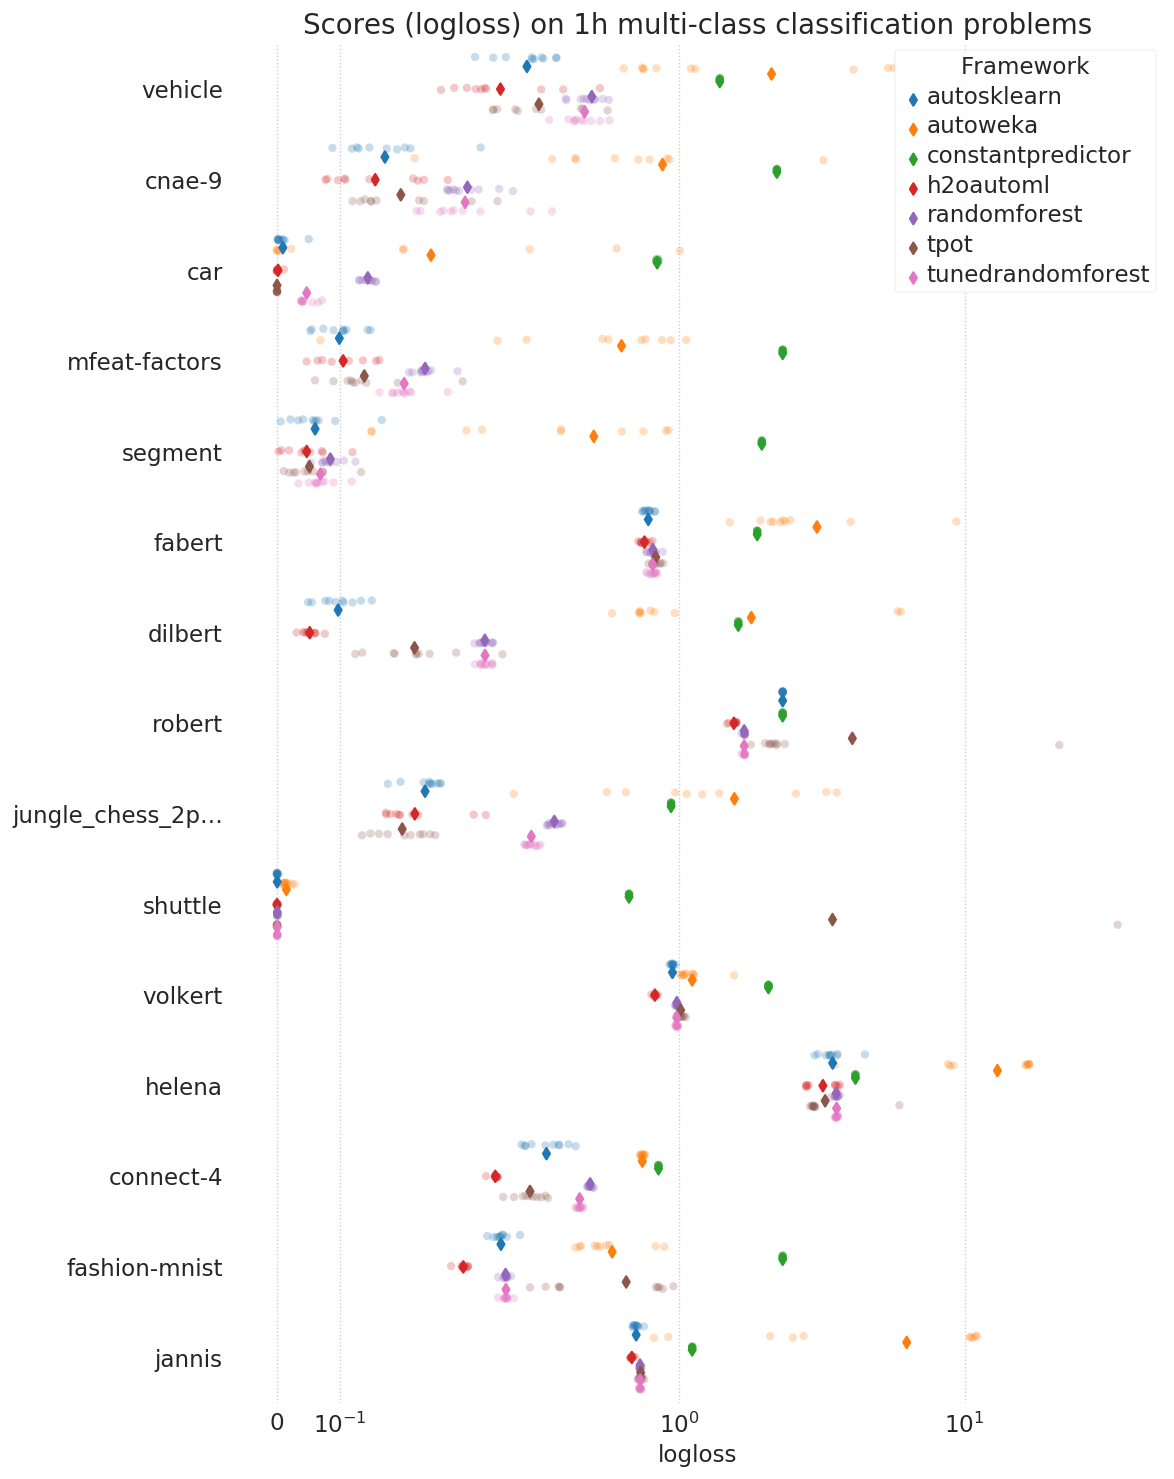

In [49]:
draw_score_stripplot('imp_result',
                     results=scatterplot_results,
                     type_filter='multiclass', 
                     metadata=res.metadata,
                     y_sort_by=tasks_sort_by,
#                      xbound=(0,10),
                     xscale=('symlog', dict(linthreshx=0.5)),
                     title=f"Scores ({multiclass_score_label}) on {results_group} multi-class classification problems",
                     xlabel=multiclass_score_label, 
                     filename="multiclass_results_stripplot.png");

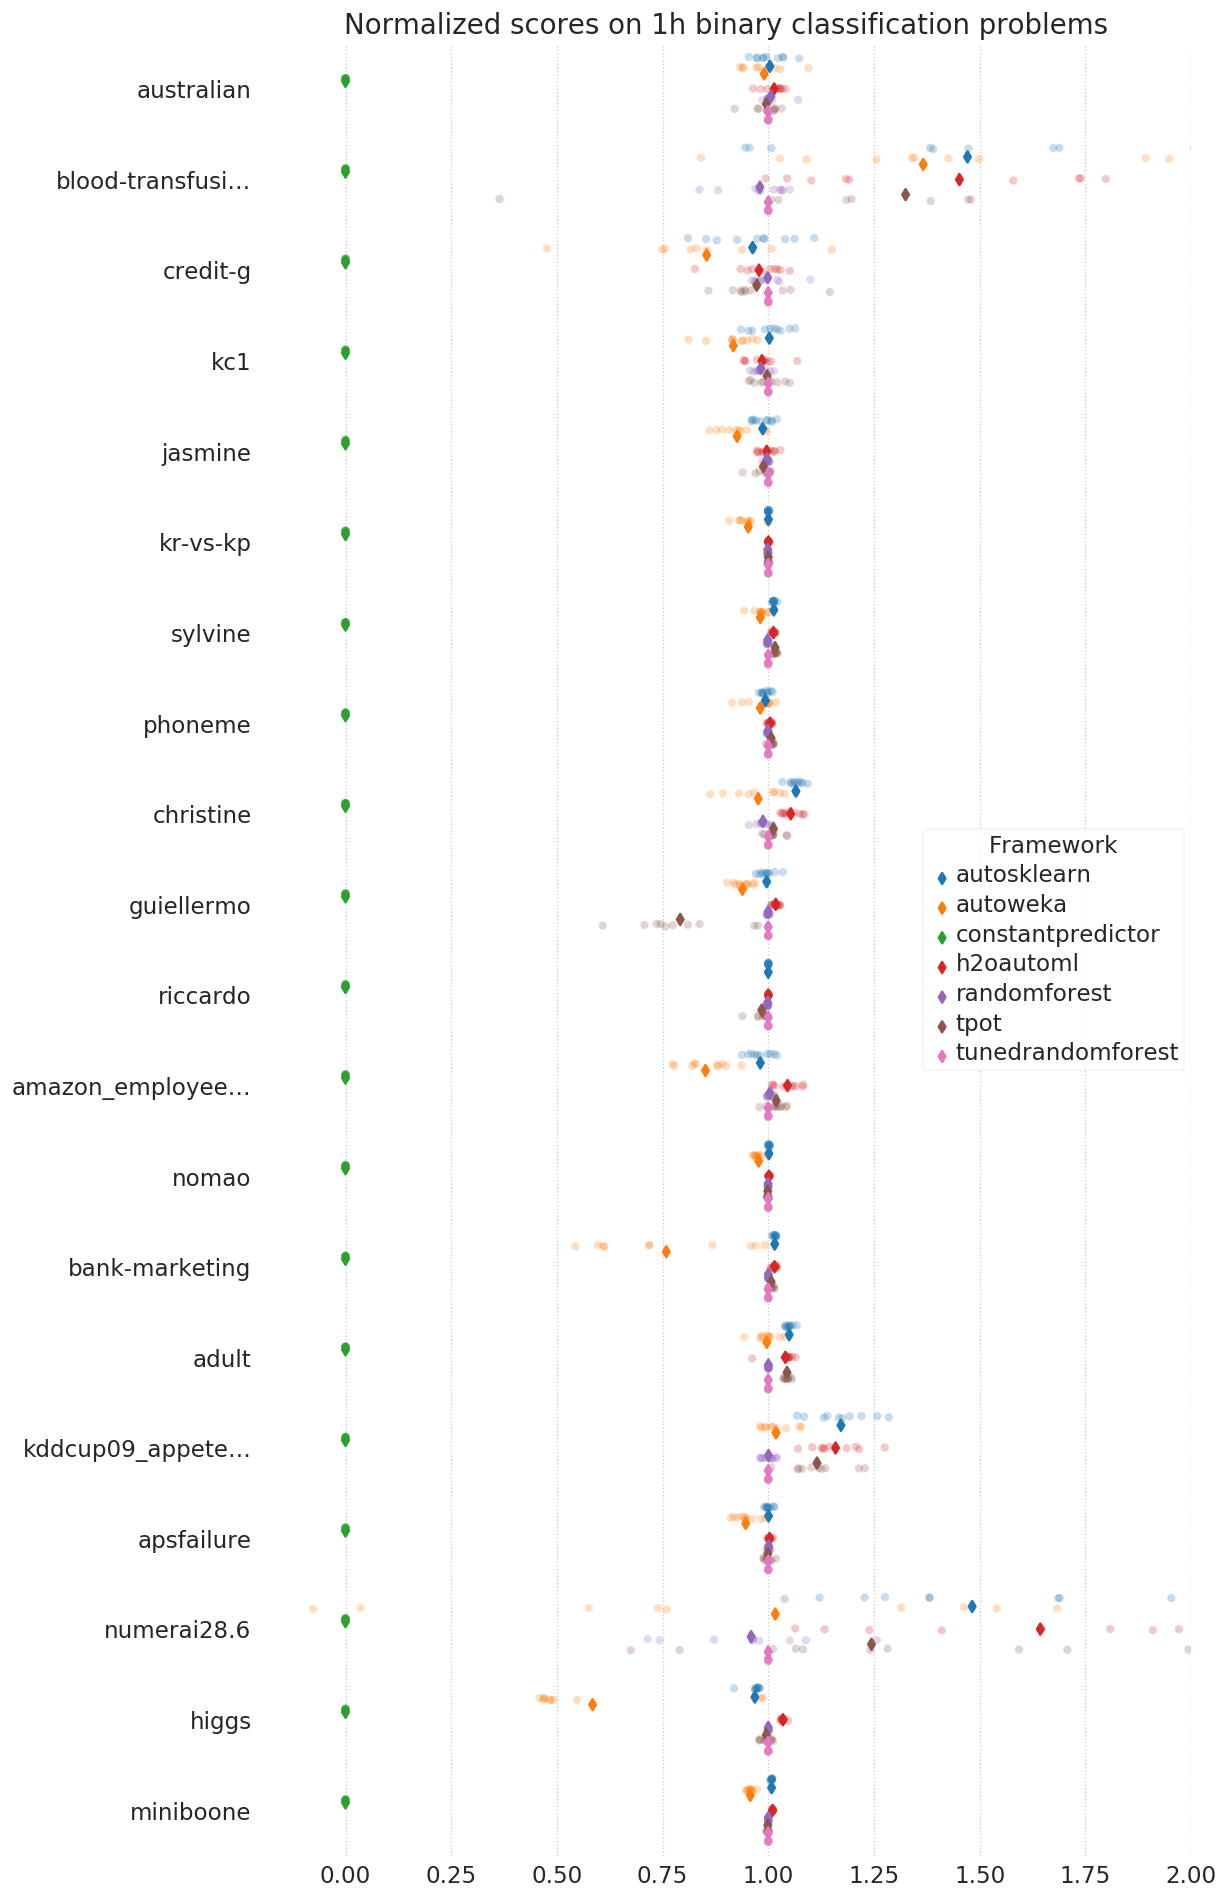

In [47]:
draw_score_stripplot('norm_score', 
                     results=scatterplot_results,
                     type_filter='binary', 
                     metadata=res.metadata,
                     y_sort_by=tasks_sort_by,
                     xbound=(-0.2, 2),
                     xscale='linear',
                     title=f"Normalized scores on {results_group} binary classification problems",
                     filename="binary_norm_score_stripplot.png");

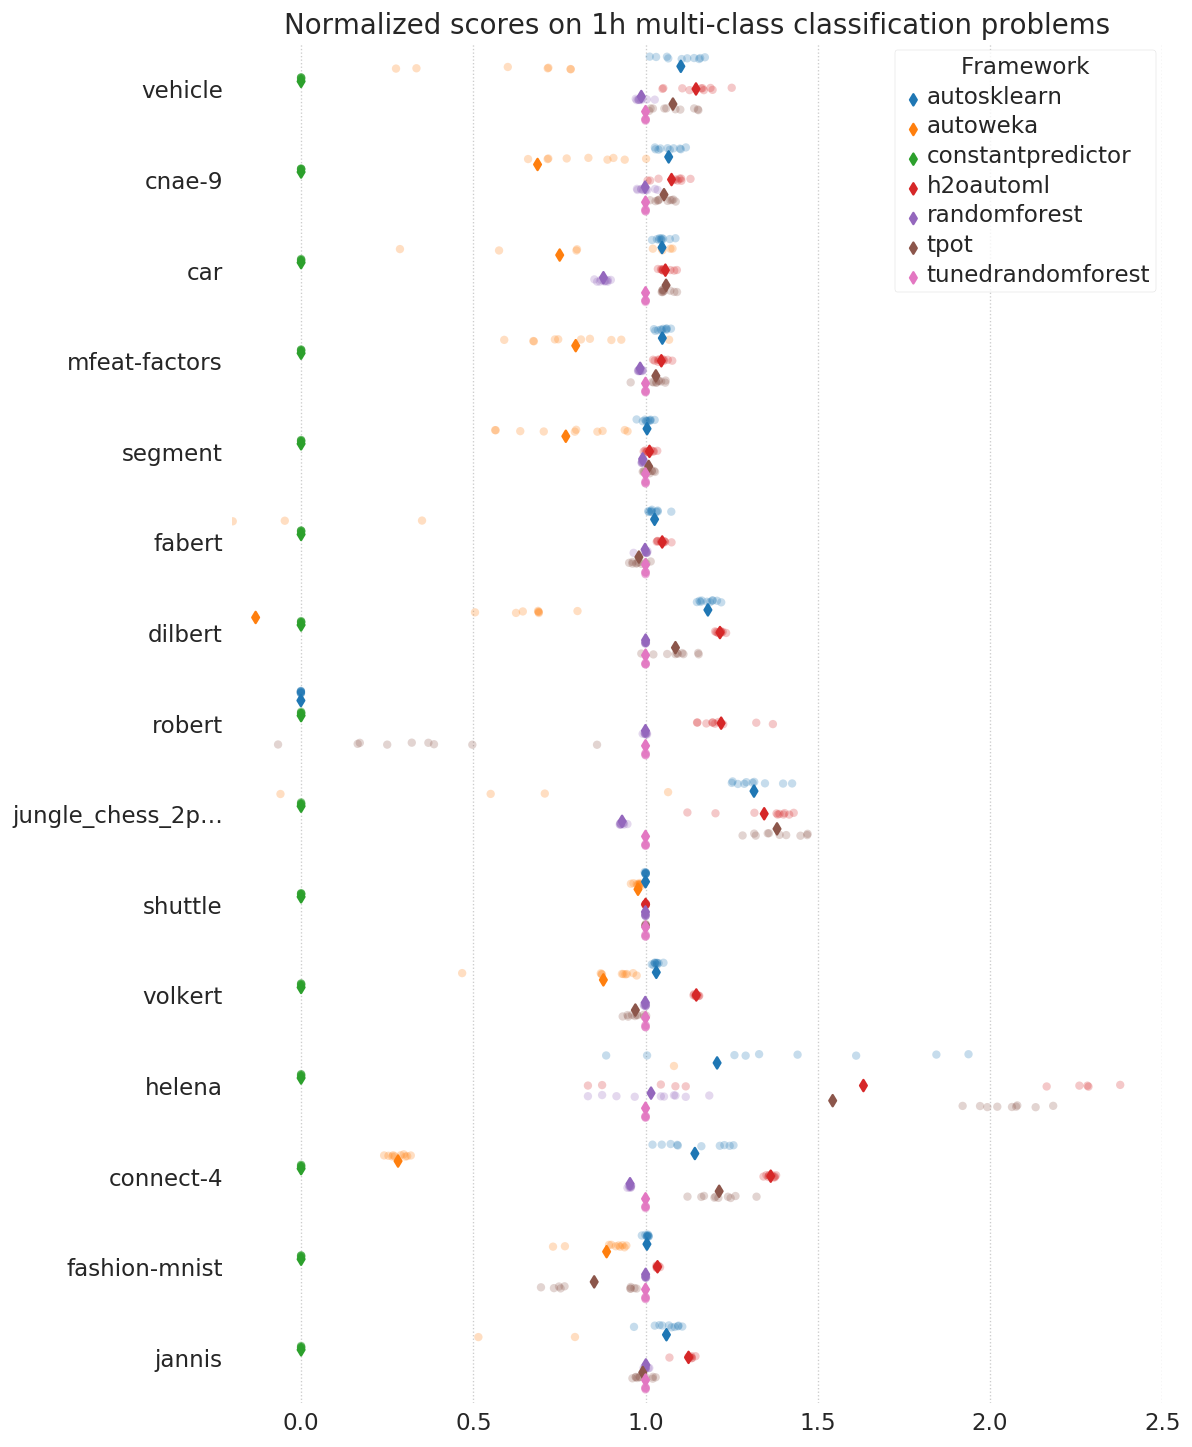

In [48]:
draw_score_stripplot('norm_score', 
                     results=scatterplot_results,
                     type_filter='multiclass', 
                     metadata=res.metadata,
                     y_sort_by=tasks_sort_by,
                     xbound=(-0.2, 2.5),
                     xscale='linear',
                     title=f"Normalized scores on {results_group} multi-class classification problems",
                     filename="multiclass_norm_score_stripplot.png");

# Comparisons

## New Framework Results

## Playground

In [ ]:
res.results.loc[(res.results.task.str.contains('jungle'))&(res.results.framework=='tunedrandomforest')];

In [ ]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints);

In [ ]:
failures = res.failed.groupby(['task', 'fold', 'framework'])['info']\
                     .unique()
#display(failures)

In [ ]:
h2o_res = (res.results.loc[(res.results.framework=='h2oautoml')&(res.results.fold==0)]
                     [['task', 'result', 'acc']])
# display(tabulate(h2o_res, h2o_res.columns, tablefmt='grid'))
display(h2o_res)